In [1]:
import numpy as np
import os
from scipy.misc import imread
import pickle
def load_CIFAR_batch(filename):
    
    with open(filename,'rb') as f:
        datadict= pickle.load(f,encoding='bytes')
        X=datadict[b'data']
        Y=datadict[b'labels']
        X=X.reshape(10000,3,32,32).transpose(0,2,3,1).astype("float")
        Y=np.array(Y)
        return X,Y
    
def load_CIFAR10(root):
    
    xs=[]
    ys=[]
    for b in range(1,6):
        f=os.path.join(root,'data_batch_%d'%(b,))
        X,Y=load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr=np.concatenate(xs)
    Ytr=np.concatenate(ys)
    del X,Y
    Xte,Yte=load_CIFAR_batch(os.path.join(root,'test_batch'))
    return Xtr,Ytr,Xte,Yte

def load_tiny_imagenet(path, dtype=np.float32):
    with open(os.path.join(path, 'wnids.txt'), 'r') as f:
        wnids = [x.strip() for x in f]

    wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

    with open(os.path.join(path, 'words.txt'), 'r') as f:
        wnid_to_words = dict(line.split('\t') for line in f)
        for wnid, words in wnid_to_words.iteritems():
            wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
    class_names = [wnid_to_words[wnid] for wnid in wnids]
    X_train = []
    y_train = []
    for i, wnid in enumerate(wnids):
        if (i + 1) % 20 == 0:
            print ('loading training data for synset %d / %d' % (i + 1, len(wnids)))
        # To figure out the filenames we need to open the boxes file
        boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
        with open(boxes_file, 'r') as f:
            filenames = [x.split('\t')[0] for x in f]
        num_images = len(filenames)

        X_train_block = np.zeros((num_images, 3, 64, 64), dtype=dtype)
        y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
        for j, img_file in enumerate(filenames):
            img_file = os.path.join(path, 'train', wnid, 'images', img_file)
            img = imread(img_file)
            if img.ndim == 2:
                ## grayscale file
                img.shape = (64, 64, 1)
            X_train_block[j] = img.transpose(2, 0, 1)
        X_train.append(X_train_block)
        y_train.append(y_train_block)

    # We need to concatenate all training data
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    # Next load validation data
    with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
        img_files = []
        val_wnids = []
        for line in f:
            img_file, wnid = line.split('\t')[:2]
            img_files.append(img_file)
            val_wnids.append(wnid)
        num_val = len(img_files)
        y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
        X_val = np.zeros((num_val, 3, 64, 64), dtype=dtype)
        for i, img_file in enumerate(img_files):
            img_file = os.path.join(path, 'val', 'images', img_file)
            img = imread(img_file)
            if img.ndim == 2:
                img.shape = (64, 64, 1)
            X_val[i] = img.transpose(2, 0, 1)

    # Next load test images
    # Students won't have test labels, so we need to iterate over files in the
    # images directory.
    img_files = os.listdir(os.path.join(path, 'test', 'images'))
    X_test = np.zeros((len(img_files), 3, 64, 64), dtype=dtype)
    for i, img_file in enumerate(img_files):
        img_file = os.path.join(path, 'test', 'images', img_file)
        img = imread(img_file)
        if img.ndim == 2:
            img.shape = (64, 64, 1)
        X_test[i] = img.transpose(2, 0, 1)

    y_test = None
    y_test_file = os.path.join(path, 'test', 'test_annotations.txt')
    if os.path.isfile(y_test_file):
        with open(y_test_file, 'r') as f:
            img_file_to_wnid = {}
            for line in f:
                line = line.split('\t')
                img_file_to_wnid[line[0]] = line[1]
        y_test = [wnid_to_label[img_file_to_wnid[img_file]] for img_file in img_files]
        y_test = np.array(y_test)

    return class_names, X_train, y_train, X_val, y_val, X_test, y_test


def load_models(models_dir):
    models = {}
    for model_file in os.listdir(models_dir):
        with open(os.path.join(models_dir, model_file), 'rb') as f:
            try:
                models[model_file] = pickle.load(f)['model']
            except pickle.UnpicklingError:
                continue
    return models



In [2]:
import random
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize']=(10.0,8.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'



In [3]:
#load raw CIFAR-10 data
from IPython.extensions import autoreload

cifar10_dir='I:\Workplace\PycharmProjects\cs231n\Assignment1\cifar-10-batches-py'
X_train,y_train,X_test,y_test=load_CIFAR10(cifar10_dir)

print('Trainning data shape',X_train.shape)
print('Trainning label shape',y_train.shape)
print('Test data shape',X_test.shape)
print('Test label shape',y_test.shape)

Trainning data shape (50000, 32, 32, 3)
Trainning label shape (50000,)
Test data shape (10000, 32, 32, 3)
Test label shape (10000,)


In [4]:
 #show tiny images
classes=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes=len(classes)
samples_per_class=7
for y,cls in enumerate(classes):
    idxs=np.flatnonzero(y_train==y)
    idxs=np.random.choice(idxs,samples_per_class,replace=False)
    for i,idx in enumerate(idxs):
        plt_idx=i*num_classes+y+1
        plt.subplot(samples_per_class,num_classes,plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i==0:
            plt.title(cls)
plt.show()


In [7]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [8]:
#reshape the image data int rows
X_train=np.reshape(X_train,(X_train.shape[0],-1))
X_test=np.reshape(X_test,(X_test.shape[0],-1))

print(X_train.shape,X_test.shape)


(5000, 3072) (500, 3072)


In [5]:
class KNearestNeighbor(object):
    def __init__(self):
        pass
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distance_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distance_one_loop(X)
        elif num_loops == 2:
            dists = self.compute_distance_two_loop(X)
        else:
            raise ValueError('Invalid input')
        return self.predict_labels(dists, k=k)
    def compute_distance_two_loop(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            for j in range(num_train):
                dists[i][j] = np.sum((X[i] - self.X_train[j]) ** 2)
        return dists
    def compute_distance_no_loops(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        dists += np.sum(self.X_train ** 2, axis=1).reshape(1, num_train)
        dists += np.sum(X ** 2, axis=1).reshape(num_test, 1)  # reshape for broadcasting
        temp = 2 * np.dot(X, self.X_train.T)
        dists -= temp
        return dists

    def compute_distance_one_loop(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            dists[i] = np.sum((self.X_train - X[i]) ** 2, 1)
        return dists
    def predict_labels(self, dists, k):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            closest_y = self.y_train[np.argsort(dists[i])[0:k]]
            y_pred[i] = np.bincount(closest_y).argmax()
        return y_pred


classifier = KNearestNeighbor()
classifier.train(X_train, y_train)


In [9]:

dist=classifier.compute_distance_no_loops(X_test)
print(dist.shape)



(500, 50000)


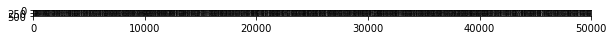

In [10]:
plt.imshow(dist,interpolation='none')
plt.show()

In [12]:
y_test_pred=classifier.predict_labels(dist,k=1)
num_correct=np.sum(y_test_pred==y_test)
accuracy=float(num_correct)/num_test
print('Got %d / %d  correct => accuracy: %f'%(num_correct,num_test,accuracy))



Got 164 / 500  correct => accuracy: 0.328000


In [13]:
dists_one=classifier.compute_distance_no_loops(X_test)
difference=np.linalg.norm(dist-dists_one,ord='fro')
print('Difference was : ',difference)
if difference < 0.001:
    print("Good! The distance matrices are the same")
else:
    print("Bad! The distance matrices are different")
    

Difference was :  0.0
Good! The distance matrices are the same


In [16]:
def time_function(f,*args):
    import time
    tic=time.time()
    f(*args)
    toc=time.time()
    return toc-tic

two_loop_time=time_function(classifier.compute_distance_two_loop,X_test)
print('two loop version took %f seconds'%two_loop_time)
one_loop_time=time_function(classifier.compute_distance_one_loop,X_test)
print('one loop version took %f seconds'%one_loop_time)
no_loop_time=time_function(classifier.compute_distance_no_loops,X_test)
print('no loop version took %f seconds'%no_loop_time)



two loop version took 416.654975 seconds


one loop version took 836.119833 seconds


no loop version took 4.454170 seconds


In [25]:
num_folds=5
K_choices=[1,3,5,10,12,15,20,50,100]

X_train_folds=[]
y_train_folds=[]

avg_size=int(X_train.shape[0]/num_folds)
for i in range(num_folds):
    X_train_folds.append(X_train[i*avg_size:(i+1)*avg_size])
    y_train_folds.append(y_train[i*avg_size:(i+1)*avg_size])
    
k_to_accuracies={}

for k in K_choices:
    accuracies = []
    print (k)
    for i in range(num_folds):
        X_train_cv = np.vstack(X_train_folds[0:i] + X_train_folds[i+1:])
        y_train_cv = np.hstack(y_train_folds[0:i] + y_train_folds[i+1:])
        X_valid_cv = X_train_folds[i]
        y_valid_cv = y_train_folds[i]
        classifier.train(X_train_cv, y_train_cv)
        dists = classifier.compute_distance_no_loops(X_valid_cv)
        accuracy = float(np.sum(classifier.predict_labels(dists, k) == y_valid_cv)) / y_valid_cv.shape[0]
        accuracies.append(accuracy)
        k_to_accuracies[k]=accuracies

for k in sorted(k_to_accuracies):
     for a in k_to_accuracies[k]:
         print('k = %d, accuracy = %f'%(k,a))


1


3


5


10


12


15


20


50


100


k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accuracy = 0.279000
k = 20, accuracy = 0.279000
k = 20, accuracy = 0.282000
k = 20, accuracy = 0.285000
k = 50, accuracy = 0.271000
k = 50,

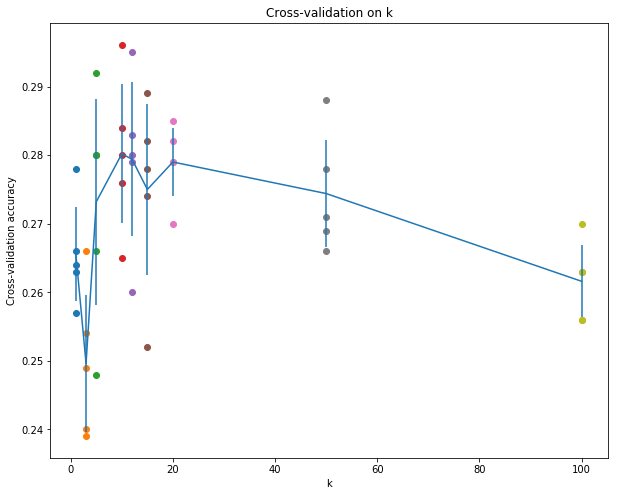

In [26]:
for k in K_choices:
    accuracies=k_to_accuracies[k]
    plt.scatter([k]*len(accuracies),accuracies)

accuracies_mean=np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std=np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(K_choices,accuracies_mean,yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()
    
    
    

In [27]:

best_k=10
classifier=KNearestNeighbor()
classifier.train(X_train,y_train)
y_test_pred=classifier.predict(X_test,k=best_k)

num_correct=np.sum(y_test==y_test_pred)
accuracy=float(num_correct)/num_test
print('Got %d / %d correct => accuracy: %f'%(num_correct,num_test,accuracy))


Got 141 / 500 correct => accuracy: 0.282000
